In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import cvxpy as cvx
import skimage as ski
import skimage.io
import skimage.transform
import scipy.fftpack as spfft # for discrete cosine transform 

In [30]:
# construct DCT matrix
def construct_DCT_Mat( Nx, Ny ):
    # input : Nx number of columns of image 
    #         Ny number of rows of image 

    # output: D DCT matrix mapping image.flatten() to 
    #         DCT(image).flatten()
    Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')
    Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')
    D = np.kron(Dy, Dx)

    return D

In [31]:
# construct inverse DCT matrix
def construct_iDCT_Mat( Nx, Ny ):

    # input : Nx number of columns of image 
    #         Ny number of rows of image 

    # output: iD iDCT matrix mapping DCT(image).flatten() to 
    #         image.flatten()
    Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')
    Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')
    D = np.kron(Dy, Dx)

    return D

Original size:  (292, 228)
Rescaled size:  (53, 41)


C:\Users\pwest\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


Text(0.5, 1.0, 'Rescaled image')

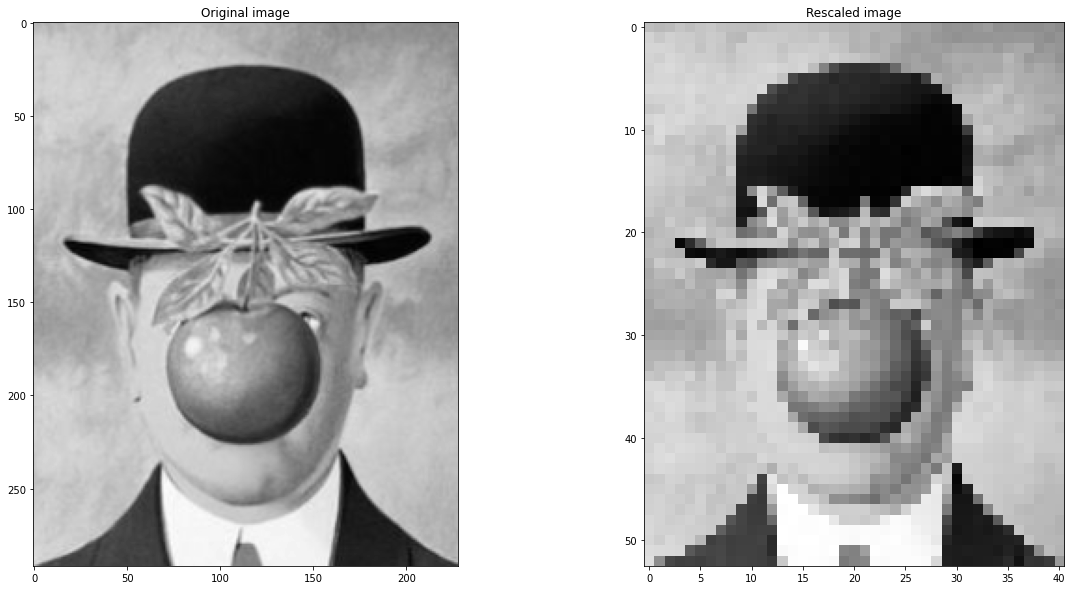

In [32]:
# import image and rescale 
img_path = './SonOfMan.png'

# read image
img_og = ski.io.imread(img_path)

# convert to grayscale and visualize 
img_og = ski.color.rgb2gray(img_og)
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(img_og, cmap = 'gray')
ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# resize image 
img = ski.transform.rescale( img_og, 0.18, anti_aliasing=False)

print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image")

# Task 1 - Image Compression

In [33]:
# Generate DCT and iDCT
mat_DCT = construct_DCT_Mat(41, 53)
mat_iDCT = construct_iDCT_Mat(41, 53)
print(mat_DCT.shape, mat_iDCT.shape)

(2173, 2173) (2173, 2173)


In [34]:
# Flatten Image
image_flat = img.flatten()
print(image_flat.shape)

(2173,)


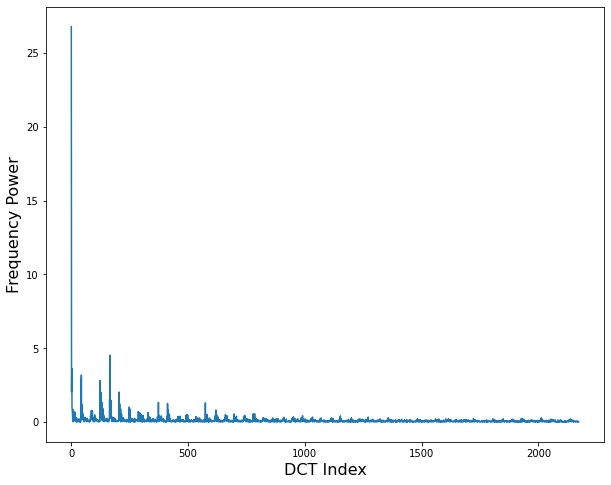

In [44]:
# Apply DCT
dct_img = np.dot(mat_DCT, image_flat)

# Plot DCT of image
fig = plt.figure(figsize=(10, 8))
plt.plot(np.abs(dct_img))
plt.xlabel('DCT Index', fontsize=16)
plt.ylabel('Frequency Power', fontsize=16)
plt.savefig('./Frequency_Power.pdf', bbox_inches='tight')
plt.show()

In [36]:
# Keep only a certain amount of threshold and inverse transform image
keep_vals = [0.05, 0.1, 0.2, 0.4]
max_val = np.max(np.abs(dct_img))
results = np.empty((len(keep_vals), len(dct_img)))
for idx, k in enumerate(keep_vals):
    thresh = np.percentile(dct_img, 100 * (1 - k)) # Find percentile
    res = np.where(np.abs(dct_img) >= thresh, dct_img, 0) # Keep coefficients
    results[idx, :] = np.dot(mat_iDCT, res)

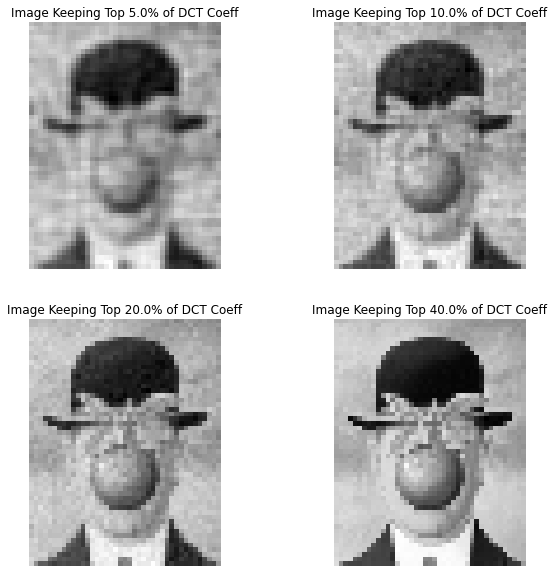

In [37]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
idx = 0 # Data index
for i in range(2):
    for j in range(2):    
        ax[i][j].imshow(results[idx, :].reshape(53, 41), cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('Image Keeping Top ' + \
                           str(100 * keep_vals[idx]) + '% of DCT Coeff' )
        idx += 1
plt.savefig('./Compressed_Images.pdf', bbox_inches='tight')
plt.show()

# Task 2 - Compressed Image Recovery

In [38]:
# Construct Measurement Matrix by sampling identity
def constructMeasurementMatrix(M, N):
    '''
    Takes in following and sample NxN identity matrix:
        M rows to sample
        N columns
        rand_state
    Returns:
        B = MxN matrix
    '''
    i_mat = np.identity(N)
    sample_rows = np.random.permutation(N)
    B = i_mat[sample_rows[:M], :].copy()
    
    return B

In [39]:
# Run Optimization Model and return results
def recoverImage(M, flat_image, i_dct):
    '''
    Inputs:
        M - number of rows to use for B matrix
        flat_image - image flattened to 1D
        i_dct - 2 dimensional inverse DCT matrix
    '''
    N = len(flat_image) # Length of flattened image
    B_mat = constructMeasurementMatrix(M, N) # Construct B matrix
    y = np.dot(B_mat, image_flat) # construct target estimate
    A_mat = np.dot(B_mat, i_dct) # Construct A matrix
    x = cvx.Variable(N) # Solution Variable
    prob = cvx.Problem(cvx.Minimize(cvx.norm(x, 1)), [A_mat @ x == y]) # Create Model
    result = prob.solve(feastol=1e-2, reltol=1e-2) # Solve Model (NOTE: cvxopt was giving errors)
    return np.dot(mat_iDCT, x.value) # Answer is the DCT

In [40]:
# Run test cases
import math
N = len(image_flat) # Flattened Image
M = [math.ceil(m * N) for m in [0.2, 0.4, 0.6]]
runs_per_m = 3 # How many runs per m?
results = np.empty((runs_per_m * len(M), N)) # For storing results
res_idx = 0
for m in M:
    for i in range(runs_per_m):
        results[res_idx, :] = recoverImage(m, image_flat, mat_iDCT)
        res_idx += 1

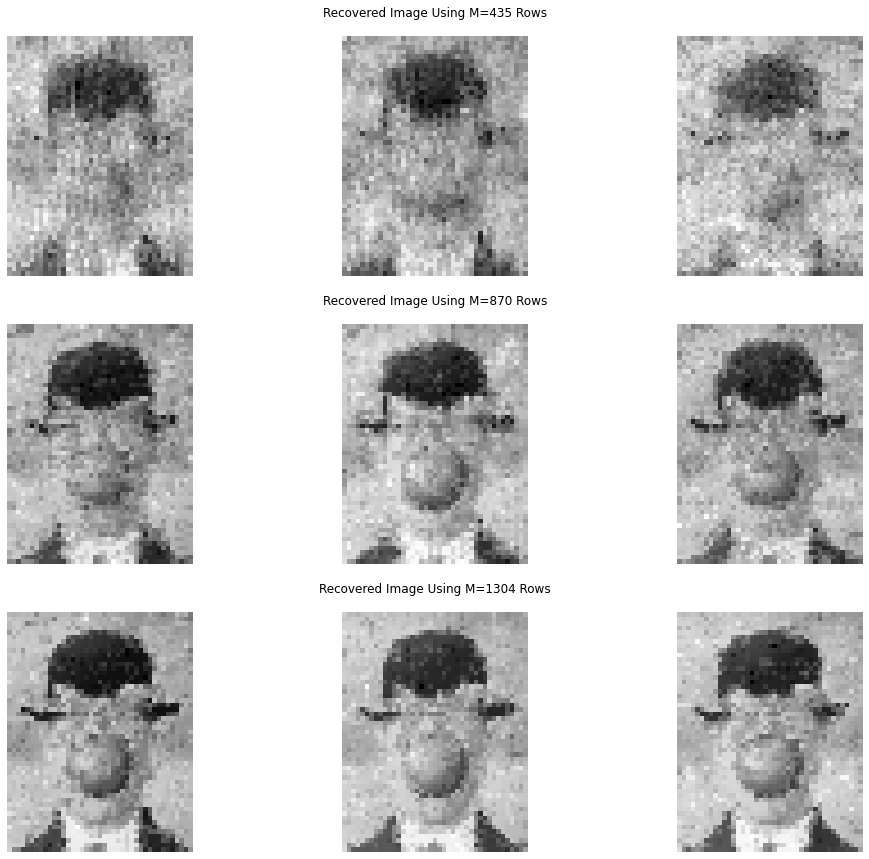

In [41]:
# Generate Plots
res_idx = 0
fig, ax = plt.subplots(3, 3, figsize=(17,15))
for i in range(3):
    m_val = M[i]
    for j in range(3):
        ax[i][j].imshow(results[res_idx, :].reshape(53, 41), cmap='gray')
        ax[i][j].axis('off')
        if j == 1:
            ax[i][j].set_title('Recovered Image Using M=' + str(m_val) + ' Rows', pad=20)
        res_idx += 1
plt.savefig('./Recovered_Images.pdf', bbox_inches='tight')
plt.show()

In [42]:
# Read in and Recover unknown image
with np.load('./UnknownImage.npz') as unknown:
    B_unknown = unknown['B']
    y_unknown = unknown['y']

N = 50*50 # Size of flattened image
iDCT_unknown = construct_iDCT_Mat(50, 50) # Inverse DCT matrix
A_unknown = np.dot(B_unknown, iDCT_unknown) # Generate A matrix
x = cvx.Variable(N)
prob = cvx.Problem(cvx.Minimize(cvx.norm(x, 1)), 
                   [A_unknown @ x == y_unknown]) # Create Model
result = prob.solve(feastol=1e-2, reltol=1e-2) # Solve Model (NOTE: cvxopt was giving errors)
recovered = np.dot(iDCT_unknown, x.value) # Answer is the DCT

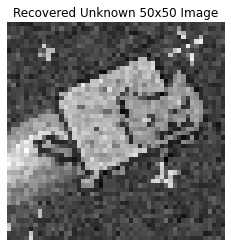

In [43]:
# Plot Result
plt.imshow(recovered.reshape(50, 50), cmap='gray')
plt.title('Recovered Unknown 50x50 Image')
plt.axis('off')
plt.savefig('./Recovered_Image.pdf', bbox_inches='tight')